In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import lfilter
import numpy as np

In [2]:
def load_measurement_csv(path, offset=0, filter=True):
    
    dataframe = pd.read_csv(path)
    dataframe.loc[:,'Time(ns)'] /= 1000000
    dataframe.loc[:,'Vol(V)'] = dataframe.loc[:,'Vol(V)'] * 1000 + offset

    if filter:
        n = 50  # the larger n is, the smoother curve will be
        b = [1.0 / n] * n
        a = 1
    
        dataframe.loc[:,'Vol(V)'] = lfilter(b, a, dataframe.loc[:,'Vol(V)'])
    
    return dataframe.rename(columns={'Time(ns)': 'Time(ms)', 'Vol(V)': 'Voltage(mV)'})

schunt_value = 0.05
def convert_to_current(dataframe):
    dataframe = dataframe.copy()
    dataframe.loc[:,'Voltage(mV)'] /= schunt_value
    return dataframe.rename(columns={'Voltage(mV)': 'Current(mA)'})

power_supply_voltage = 5
def convert_to_power(dataframe):
    dataframe = dataframe.copy()
    dataframe.loc[:,'Current(mA)'] *= power_supply_voltage
    return dataframe.rename(columns={'Current(mA)': 'Power(mW)'})

In [3]:
time_step_ns = 1000

def plot_raw_data(data, xaxis, yaxis, samples_ms=600,):
    # Take a 600ms of data
    n_steps = int(samples_ms * 1000000 / time_step_ns)

    fig, ax = plt.subplots()
    data.head(n_steps).plot(x='Time(ms)', ax=ax, legend=False)
    ax.set_xlabel(xaxis)
    ax.set_ylabel(yaxis)

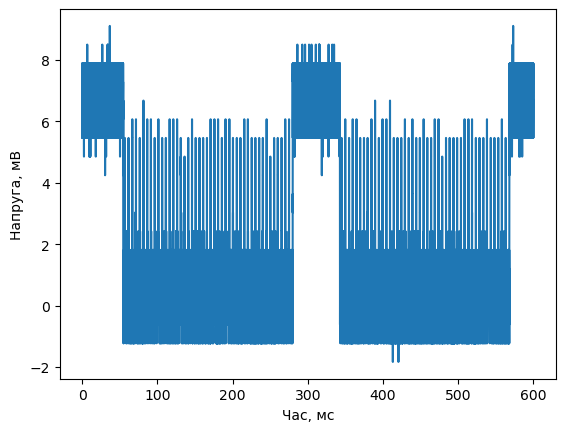

In [4]:
measurement_voltage = load_measurement_csv('power_data/cnn_not_optimised_int8_quant_tflite.csv', offset=2, filter=False)
plot_raw_data(measurement_voltage, 'Час, мс', 'Напруга, мВ')

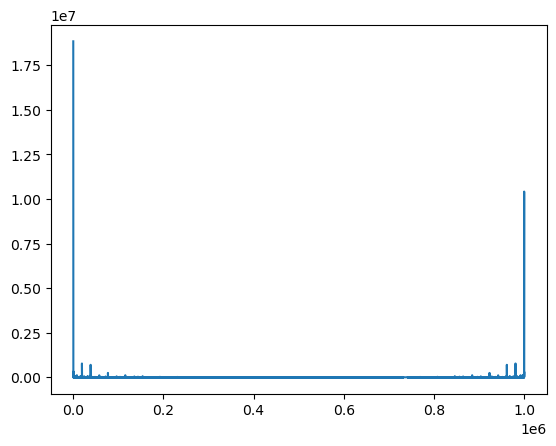

In [27]:
measurement_voltage = load_measurement_csv('power_data/cnn_not_optimised_int8_quant_tflite.csv', offset=2, filter=False)

from scipy.fft import fft

vf = fft(np.array(measurement_voltage['Voltage(mV)']))
plt.plot(np.linspace(0, 1000000, len(vf)), abs(vf), )

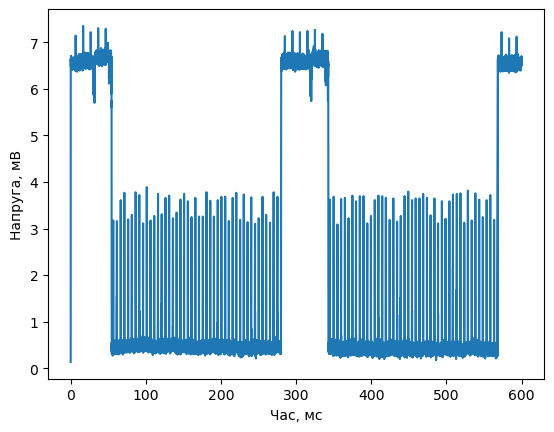

In [5]:
measurement_voltage = load_measurement_csv('power_data/cnn_not_optimised_int8_quant_tflite.csv', offset=2, filter=True)
plot_raw_data(measurement_voltage, 'Час, мс', 'Напруга, мВ')

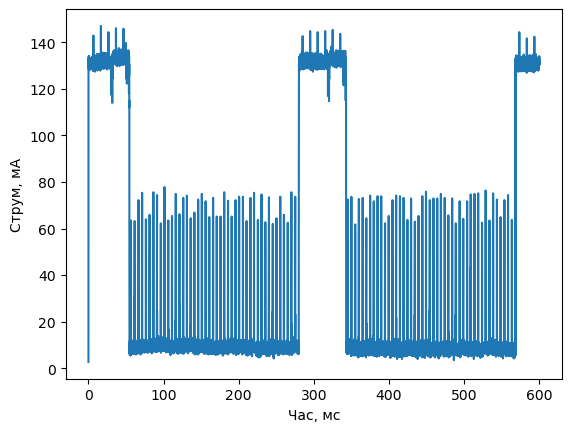

In [6]:
measured_current = convert_to_current(measurement_voltage)
plot_raw_data(measured_current, 'Час, мс', 'Струм, мА')

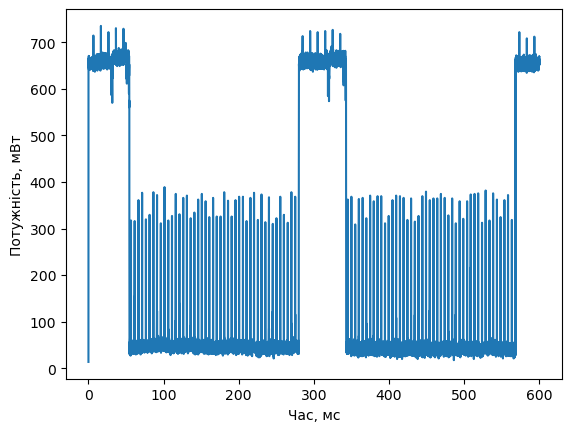

In [7]:
measured_power = convert_to_power(measured_current)
plot_raw_data(measured_power, 'Час, мс', 'Потужність, мВт')

In [8]:
time_values_s = measured_power['Time(ms)'].to_numpy() / 1000
power_values_w = measured_power['Power(mW)'].to_numpy() / 1000
np.trapz(power_values_w, x=time_values_s)

1.8843889966249991

In [9]:
time_step_ns = 1000

def plot_raw_data_2_plots_w_text(data1, data2, xaxis1, yaxis1, xaxis2, yaxis2, text, samples_ms=600):
    # Take a 600ms of data
    n_steps = int(samples_ms * 1000000 / time_step_ns)

    fig, ax = plt.subplots(2)
    data1.head(n_steps).plot(x='Time(ms)', ax=ax[0], legend=False)
    data2.head(n_steps).plot(x='Time(ms)', ax=ax[1], legend=False)
    ax[0].set_xlabel(xaxis1)
    ax[0].set_ylabel(yaxis1)
    ax[1].set_xlabel(xaxis2)
    ax[1].set_ylabel(yaxis2)
    #ax[1].text(
    #    0.83,
    #    0.83,
    #    text,
    #    wrap=True,
    #    horizontalalignment='left',
    #    verticalalignment='center',
    #)
    
def plot_raw_data_multi_plots_w_text(data, xaxiss, yaxiss, titles, samples_ms=600):
    # Take a 600ms of data
    n_steps = int(samples_ms * 1000000 / time_step_ns)

    fig, ax = plt.subplots(len(data), figsize=(12, 10), sharex=True)
    # data1.head(n_steps).plot(x='Time(ms)', ax=ax[0], legend=False)
    # data2.head(n_steps).plot(x='Time(ms)', ax=ax[1], legend=False)
    # ax[0].set_xlabel(xaxis1)
    # ax[0].set_ylabel(yaxis1)
    # ax[1].set_xlabel(xaxis2)
    # ax[1].set_ylabel(yaxis2)
    for i in range(len(data)):
        data[i].head(n_steps).plot(x='Time(ms)', ax=ax[i], legend=False, color='green')
        ax[i].set_xlabel(xaxiss[i])
        ax[i].set_ylabel(yaxiss[i])
        ax[i].set_title(titles[i])

    plt.tight_layout()
        

In [10]:
def analyze_measurement(measured_voltage, name):
    measured_current = convert_to_current(measurement_voltage)
    measured_power = convert_to_power(measured_current)

    #plot_raw_data(measurement_voltage, 'Час, мс', 'Напруга, мВ')
    #plot_raw_data(measured_current, 'Час, мс', 'Струм, мА')
    #plot_raw_data(measured_power, 'Час, мс', 'Потужність, мВт')
    
    time_values_s = measured_power['Time(ms)'].to_numpy() / 1000
    power_values_w = measured_power['Power(mW)'].to_numpy() / 1000

    power_ws_used = np.trapz(power_values_w, x=time_values_s)
    mean_power = power_ws_used / 10 # All samples was measured for exactly 10 seconds
    plot_raw_data_2_plots_w_text(measured_current, measured_power, 'Час, мс', 'Струм, мА', 'Час, мс', 'Потужність, мВт', f'Середнє споживання {mean_power*1000:.2}мВт')
    print(f'Загальні витрати електроенергії (протягом 10с роботи) {power_ws_used/3600}Вт*год (середнє {mean_power}Вт)')
    return measured_power


def analyze_measurement_multi(measured_voltages, names):
    measured_currents = tuple(convert_to_current(measurement_voltage) for measurement_voltage in measured_voltages)
    measured_powers = tuple(convert_to_power(measured_current) for measured_current in measured_currents)

    
    # time_values_s = measured_power['Time(ms)'].to_numpy() / 1000
    # power_values_w = measured_power['Power(mW)'].to_numpy() / 1000

    # power_ws_used = np.trapz(power_values_w, x=time_values_s)
    # mean_power = power_ws_used / 10 # All samples was measured for exactly 10 seconds
    plot_raw_data_multi_plots_w_text(measured_powers, ('Time, ms', )* len(measured_powers), ('Power, mW', )* len(measured_powers), names)
    # print(f'Загальні витрати електроенергії (протягом 10с роботи) {power_ws_used/3600}Вт*год (середнє {mean_power}Вт)')
    # return measured_power
    

In [11]:
def plot_power_measurements(measurements, titles):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))

Analyzing ./power_data/cnn_pruned_default_opt_tflite.csv
Загальні витрати електроенергії (протягом 10с роботи) 0.0004953530561449999Вт*год (середнє 0.17832710021219997Вт)
Analyzing ./power_data/cnn_not_optimised_int8_quant_tflite.csv
Загальні витрати електроенергії (протягом 10с роботи) 0.0005234413879513886Вт*год (середнє 0.1884388996624999Вт)
Analyzing ./power_data/cnn_pruned_int8_quant_tflite.csv
Загальні витрати електроенергії (протягом 10с роботи) 0.0005234413879513886Вт*год (середнє 0.1884388996624999Вт)
Analyzing ./power_data/cnn_not_optimised_default_opt_tflitecsv.csv
Загальні витрати електроенергії (протягом 10с роботи) 0.0003438191325855566Вт*год (середнє 0.12377488773080039Вт)
Analyzing ./power_data/cnn_pruned_no_opt_tflite.csv
Загальні витрати електроенергії (протягом 10с роботи) 0.00043599255688722195Вт*год (середнє 0.1569573204793999Вт)
Analyzing ./power_data/cnn_not_optimised_no_opt_tflite.csv
Загальні витрати електроенергії (протягом 10с роботи) 0.0005406895521808336Вт*

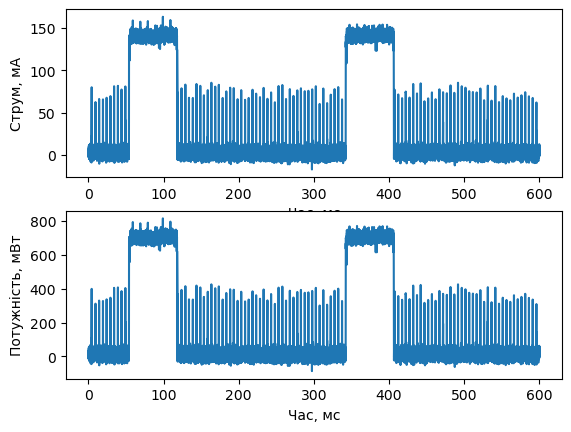

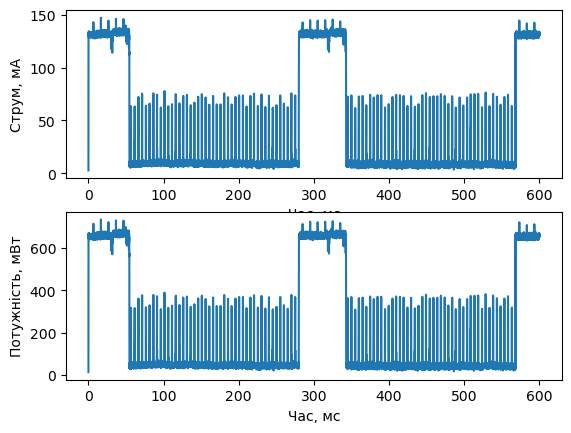

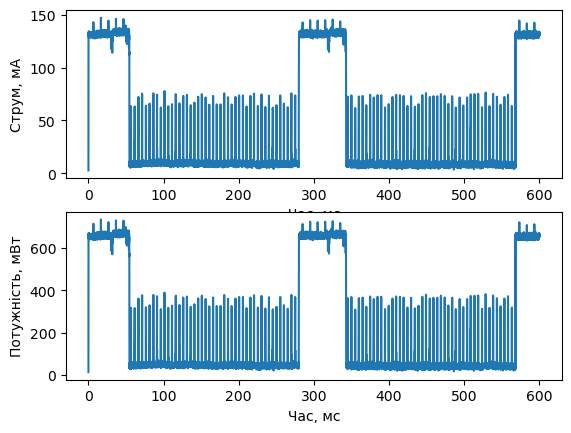

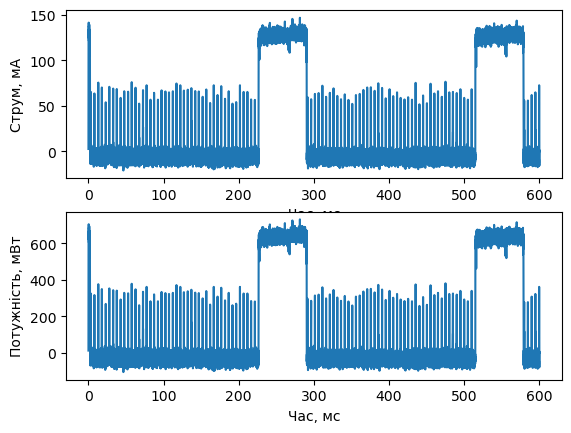

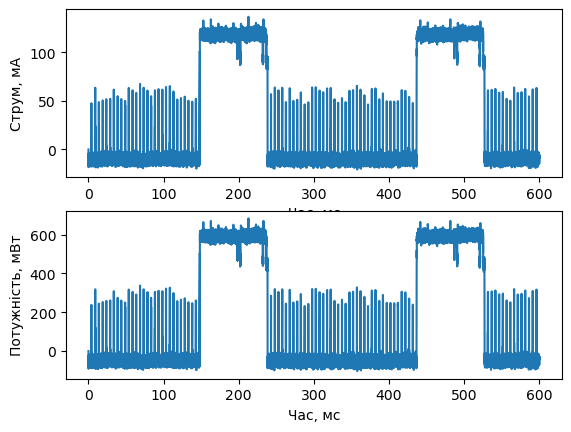

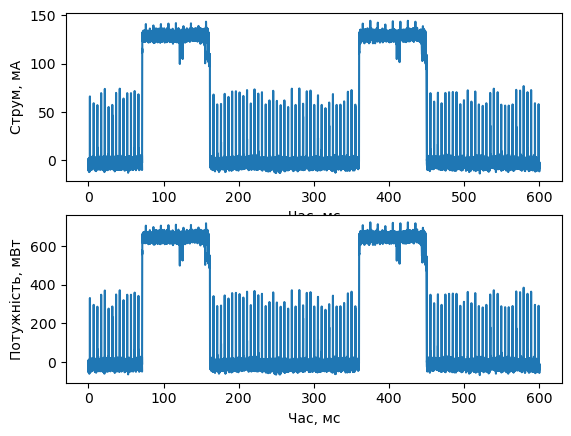

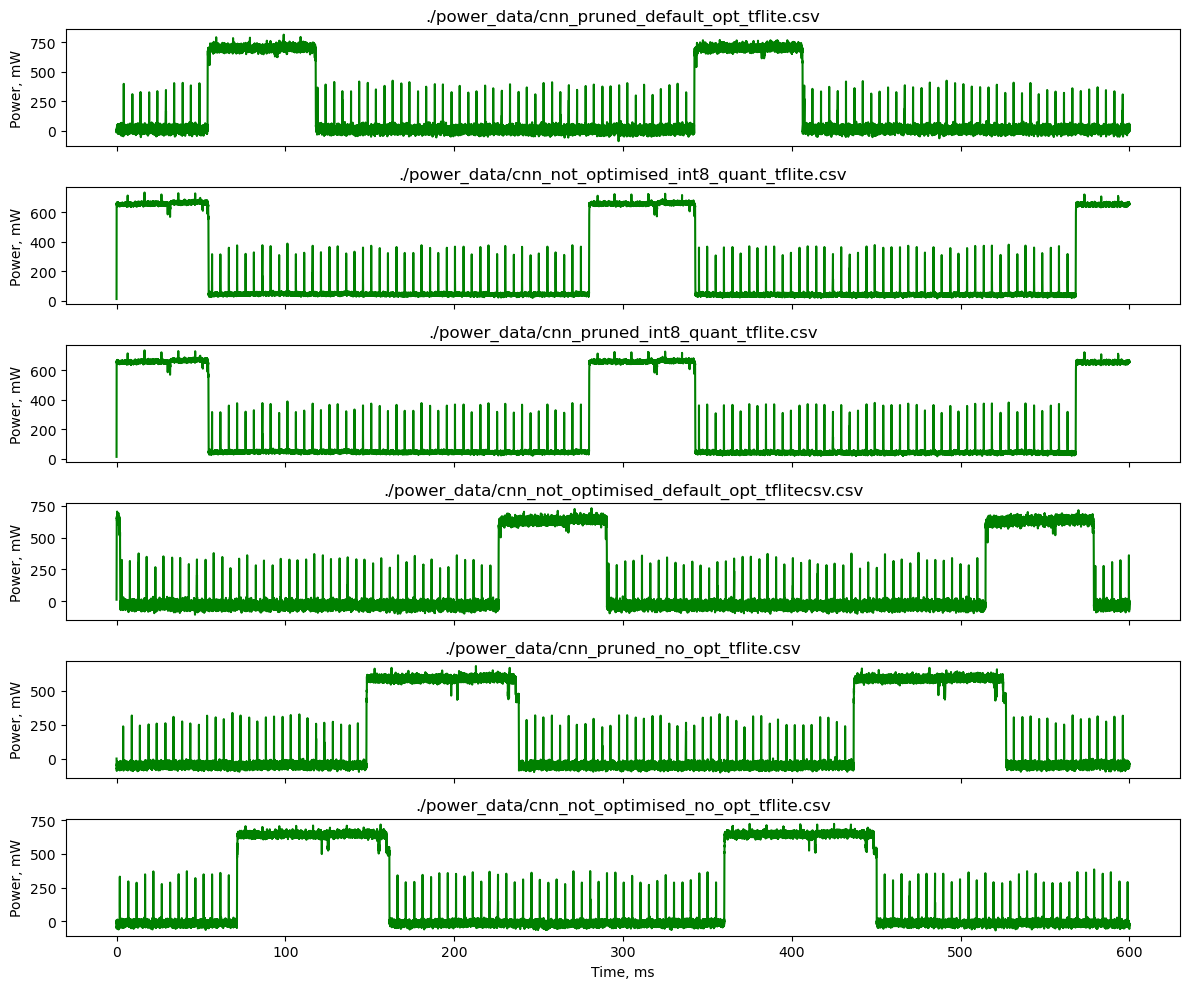

In [12]:
import glob

measured_voltages = []
filepaths = []

for filepath in glob.glob('./power_data/*.csv'):
    print(f'Analyzing {filepath}')
    if filepath == './power_data/cnn_not_optimised_int8_quant_tflite.csv' or filepath == './power_data/cnn_pruned_int8_quant_tflite.csv':
        measurement_voltage = load_measurement_csv(filepath, offset=2)
    else:
        measurement_voltage = load_measurement_csv(filepath)
    analyze_measurement(measurement_voltage, filepath)
    measured_voltages.append(measurement_voltage)
    filepaths.append(filepath)
    
analyze_measurement_multi(measured_voltages, filepaths)